# Evaluate

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import json
from pandas.io.json import json_normalize

import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.ops import box_iou

In [ ]:
from IPython.display import clear_output

MSE

In [88]:
f"MSE over counts of animals is: {mse} for {len(test_data)} images"

'MSE is: 20.0 for 480 images'

In [21]:
def convert_yolo_to_normal(bbox,size_w = 1280,size_h = 720):
    
    if len(bbox)==0:
        return []
    
    x,y,w,h = bbox[0],bbox[1],bbox[2],bbox[3]
    l_x = int((x - w / 2) * size_h)
    r_x = int((x + w / 2) * size_h)
    l_y = int((y - h / 2) * size_w)
    r_y = int((y + h / 2) * size_w)

    if l_x < 0:
        l_x = 0
    if r_x > size_w - 1:
        r_x = size_w - 1
    if l_y < 0:
        l_y = 0
    if r_y > size_h - 1:
        b = size_h - 1
    
    return torch.tensor([[l_x,l_y,r_x,r_y]])

def convert_to_float(bbox):
    res = []
    for b in parse_bbox_tuple(pd.read_csv(outdir + '/1.csv',sep = '\t')['y_true'])[0][0]:
        res.append(float(b))
    return res

def preprocess_true_val(bbox_list):
    res = []
    for bbox in bbox_list:
        bbox = convert_to_float(bbox)
        res.append( convert_yolo_to_normal(bbox = bbox) )
    return res

def process_pred_val(bbox_list):
    res = []
    for bbox in bbox_list:
        new_bbox = []
        for b in bbox:
            new_bbox.append(int(b))
        
        res.append(torch.tensor([new_bbox]) )
    return res

IoU

In [36]:
mean_iou = 0
mean_iou_each = []



num_pictures = len(os.listdir(outdir))

for file in os.listdir(outdir):
    #process true val
    y_true = parse_bbox_tuple(pd.read_csv(outdir + '/' + file,sep = '\t')['y_true'])[0]
    y_true = preprocess_true_val(y_true)

    #process true val
    y_pred = parse_bbox_tuple(pd.read_csv(outdir  + '/' + file,sep = '\t')['y_pred'])[0]
    y_pred = process_pred_val(y_pred)
    
    if len(y_true)==0 and len(y_pred)==0:
        num_pictures-=1
        #mean_iou +=1
        continue
    elif len(y_true)==0 or len(y_pred)==0:
        #mean_iou += 0
        #mean_iou_each.append(0)
        num_pictures-=1
        continue
    
    checked = []
    mean_val = 0
    for y_t in y_true:

        #print(f"true:{y_t}")
        dist = 10000
        val = torch.tensor(0)

        for j,y_p in enumerate(y_pred):
            #print(f"pred:{y_p}")
            dist_new = ((y_t - y_p)**2)[0:2].sum().item()**0.5
            if dist_new < dist and j not in checked:
                dist = dist_new
                val = box_iou(y_t,y_p)
                checked.append(j)
        mean_val+= val.item()
    mean_iou += mean_val/len(checked)
    mean_iou_each.append(mean_val)

mean_iou = mean_iou/num_pictures
mean_iou

0.05444802300543512

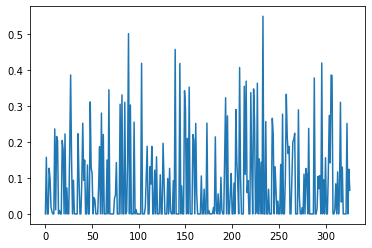

In [30]:
plt.plot(np.arange(len(mean_iou_each)),mean_iou_each)

MSE box

In [32]:
mean_iou = 0
mean_iou_each = []



num_pictures = len(os.listdir(outdir))

for file in os.listdir(outdir):
    #process true val
    y_true = parse_bbox_tuple(pd.read_csv(outdir + '/' + file,sep = '\t')['y_true'])[0]
    y_true = preprocess_true_val(y_true)

    #process true val
    y_pred = parse_bbox_tuple(pd.read_csv(outdir  + '/' + file,sep = '\t')['y_pred'])[0]
    y_pred = process_pred_val(y_pred)
    
    if len(y_true)==0 and len(y_pred)==0:
        num_pictures-=1
        #mean_iou +=1
        continue
    elif len(y_true)==0 or len(y_pred)==0:
        #mean_iou += 0
        #mean_iou_each.append(0)
        num_pictures-=1
        continue
    
    checked = []
    mean_val = 0
    for y_t in y_true:

        #print(f"true:{y_t}")
        dist = 10000
        val = torch.tensor(0)

        for j,y_p in enumerate(y_pred):
            #print(f"pred:{y_p}")
            dist_new = ((y_t - y_p)**2)[0:2].sum().item()**0.5
            if dist_new < dist and j not in checked:
                dist = dist_new
                val = ((y_t-y_p)**2)[0:2].sum()**0.5
                checked.append(j)
        mean_val+= val.item()
    mean_iou += mean_val/len(checked)
    mean_iou_each.append(mean_val)

mean_iou = mean_iou/num_pictures
mean_iou

606.0963489743011

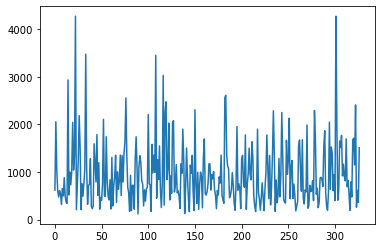

In [33]:
plt.plot(np.arange(len(mean_iou_each)),mean_iou_each)